In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm
# from tqdm.notebook import tqdm

from collections import OrderedDict, defaultdict
import itertools
from functools import partial
import datetime
from joblib import Parallel, delayed
import copy
import json

import sys; sys.path.append('../../')

from data.dataloader import get_jhu_data, get_covid19india_api_data, get_rootnet_api_data
from data.processing import get_data, get_district_time_series
from models.ihme.dataloader import get_dataframes_cached

from models.seir.seir_testing import SEIR_Testing
from main.seir.optimiser import Optimiser
from main.seir.losses import Loss_Calculator
from main.seir.fitting import single_fitting_cycle, train_val_split, calculate_loss
from main.seir.forecast import create_region_csv, create_all_csvs, write_csv, get_forecast
from viz.forecast import plot_forecast

## Comparison of E/Hosp and I/Hosp ratios

In [3]:
# for district in predictions_dict.keys():
#     district_dict = predictions_dict[district]
    
#     fig, ax = plt.subplots(figsize=(12, 12))
#     ax.plot(district_dict['m1']['df_prediction']['date'], district_dict['m1']['df_prediction']['E'] / district_dict['m1']['df_prediction']['hospitalised'],
#             '-', color='C0', label='E / Hosp (M1)')
#     ax.plot(district_dict['m1']['df_prediction']['date'], district_dict['m1']['df_prediction']['I'] / district_dict['m1']['df_prediction']['hospitalised'],
#             '-.', color='C0', label='I / Hosp (M1)')
#     ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
#     ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#     plt.ylabel('No of People')
#     plt.xlabel('Time')
#     plt.legend()
#     plt.title('I/Hosp and E/Hosp ratio for {}, {}'.format(district[0], district[1]))
#     plt.grid()
#     plt.show()

## Load Covid19india Data

In [3]:
# dataframes = get_covid19india_api_data()
dataframes = get_dataframes_cached()

../../cache/dataframes_ts_07062020.pkl
pulling from source


In [4]:
predictions_dict = {}

## Select Districts to fit on

In [5]:
# districts_to_show = [('Maharashtra', 'Pune'), 
#                      ('Maharashtra', 'Mumbai'), 
#                      ('Rajasthan', 'Jaipur'), 
#                      ('Gujarat', 'Ahmedabad'), 
#                      ('Karnataka', 'Bengaluru Urban'),
#                      ('Delhi', None)]

#districts_to_show = [('Maharashtra', 'Pune')]
districts_to_show = [('Maharashtra', 'Mumbai')]

## Perform M1 and M2 fits

In [7]:
# for state, district in districts_to_show:
#    predictions_dict[(state, district)] = {}
#    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(
#        dataframes, state, district, train_period=7, val_period=7, 
#        data_from_tracker=True, initialisation='intermediate',
#        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
#    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(
#        dataframes, state, district, train_period=7, val_period=0, 
#        data_from_tracker=True, initialisation='intermediate',
#        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])

Performing m1 fit ..
fetching from athenadb...
splitting data ..
splitting data ..
train
           state district       date  total_infected  hospitalised  recovered  \
39  maharashtra   mumbai 2020-05-22         27062.6       18979.4     7169.4   
40  maharashtra   mumbai 2020-05-23         28633.4       20125.6     7557.0   
41  maharashtra   mumbai 2020-05-24         30128.2       21171.2     7969.6   
42  maharashtra   mumbai 2020-05-25         31481.6       22092.2     8364.4   
43  maharashtra   mumbai 2020-05-26         32809.4       22914.6     8832.6   

    deceased  
39     913.8  
40     950.8  
41     987.4  
42    1025.0  
43    1062.2  
val
          state district       date  total_infected  hospitalised  recovered  \
0  maharashtra   mumbai 2020-05-27         34079.6       22561.0    10419.4   
1  maharashtra   mumbai 2020-05-28         35365.8       22215.0    12011.4   
2  maharashtra   mumbai 2020-05-29         36700.4       21910.8    13607.4   
3  maharashtra   m

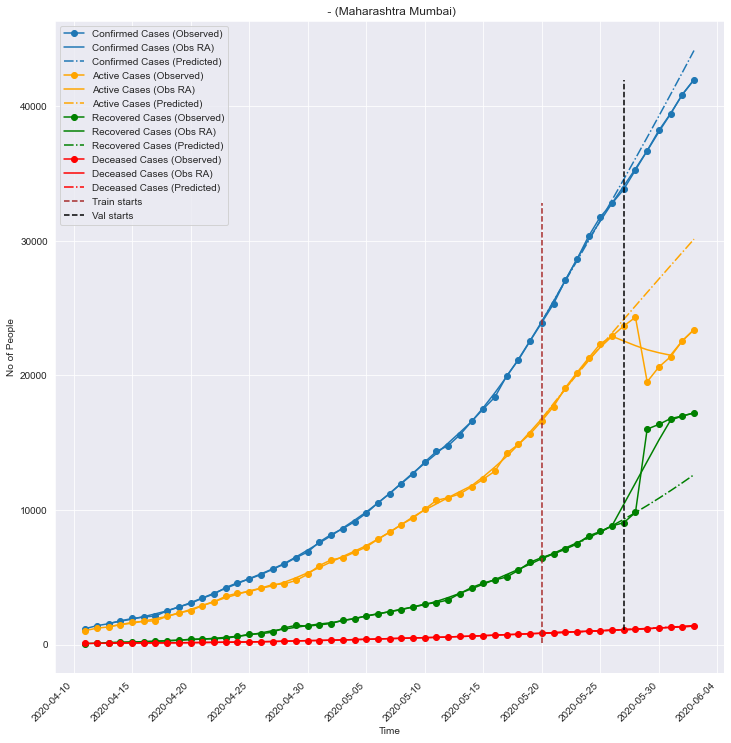

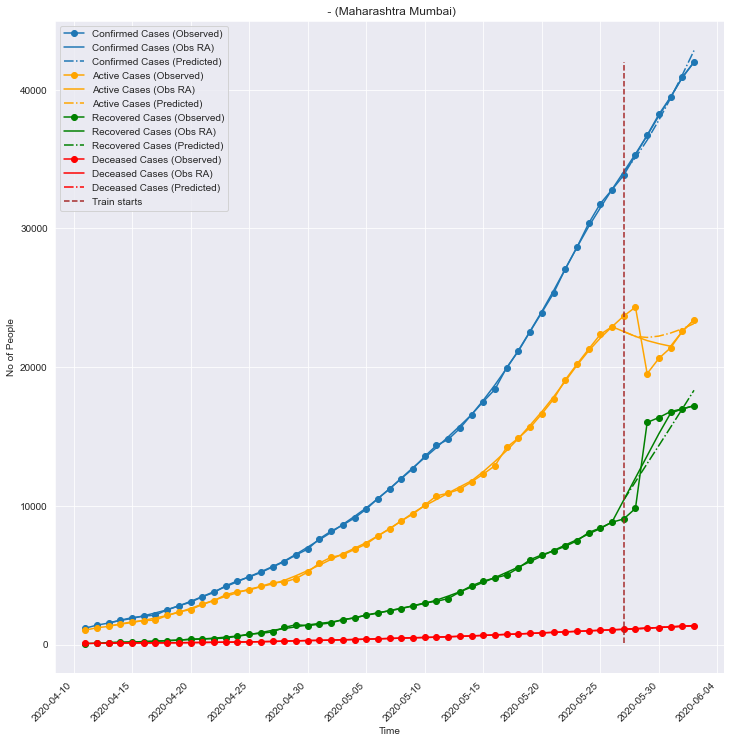

In [6]:
sns.set_style("dark")
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(
        dataframes, state, district, train_period=7, val_period=7, 
        data_from_tracker=False,
        # filename='../../data/data/official-pune-21-05-20.csv', data_format='new',
        # filename='../../data/data/official-mumbai-27-05-20.csv', data_format='old',
        initialisation='intermediate',
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered']
    )
    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(
        dataframes, state, district, train_period=7, val_period=0, 
        data_from_tracker=False, 
        # filename='../../data/data/official-pune-25-05-20.csv', data_format='new',
        # filename='../../data/data/official-mumbai-27-05-20.csv', data_format='old',
        initialisation='intermediate',
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered']
    )

## Create Master Loss Dataframe

### M1 Loss

In [7]:
predictions_dict.keys()

dict_keys([('Maharashtra', 'Mumbai')])

In [8]:
predictions_dict[('Maharashtra','Mumbai')]['m1'].keys()

dict_keys(['data_from_tracker', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'ax', 'trials', 'data_last_date', 'run_params'])

In [9]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m1']['df_loss'].columns, predictions_dict[starting_key]['m1']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in districts_to_show:
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m1']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                    \
                   hospitalised total_infected deceased recovered   
Maharashtra Mumbai         0.91           0.64     0.65      0.69   

                            val                                    
                   hospitalised total_infected deceased recovered  
Maharashtra Mumbai        17.68           3.16     1.59     33.27

### M2 Loss

In [10]:
#predictions_dict[('Maharashtra','Pune')]['m2']
predictions_dict[('Maharashtra','Mumbai')]['m2'].keys()

dict_keys(['data_from_tracker', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'ax', 'trials', 'data_last_date', 'run_params'])

In [11]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m2']['df_loss'].columns, predictions_dict[starting_key]['m2']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m2']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                  
                   hospitalised total_infected deceased recovered
Maharashtra Mumbai         5.75           0.84      0.5     11.37

## Plot Forecasts

getting forecasts ..


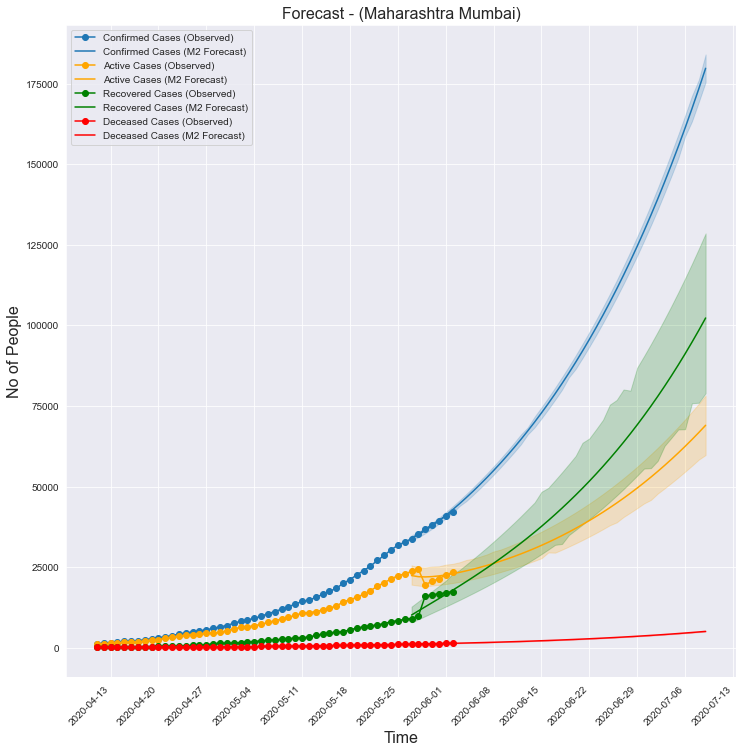

In [12]:
for region in predictions_dict.keys():
    plot_forecast(predictions_dict[region], region, both_forecasts=False, error_bars=True)

## Create and Save Output CSV

In [13]:
df_output = create_all_csvs(predictions_dict, icu_fraction=0.02)

compiling csv data ..
getting forecasts ..


In [14]:
write_csv(df_output, '../../output-mumbai-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [16]:
losses_array = np.array([trial['result']['loss'] for trial in predictions_dict[(state, district)]['m1']['trials']])
#losses_array = np.array([trial['result']['loss'] for trial in predictions_dict[(state, district)]['m2']['trials']])
least_losses_indices = np.argsort(losses_array)
losses_array[least_losses_indices][:10]

array([1.52606616, 1.75647004, 1.80342187, 1.97262928, 2.05656601,
       2.07104565, 2.18456168, 2.19766594, 2.19867336, 2.2329167 ])

In [17]:
params_array = []
for trial in predictions_dict[(state, district)]['m1']['trials']:
#for trial in predictions_dict[(state, district)]['m2']['trials']:
    params_dict = copy.copy(trial['misc']['vals'])
    for key in params_dict.keys():
        params_dict[key] = params_dict[key][0]
    params_array.append(params_dict)

params_array = np.array(params_array)

In [18]:
least_losses_indices[:10]

array([ 334, 1126,  870, 1297,  827,  788, 1299, 1298, 1344,  798])

In [19]:
params_array[least_losses_indices[:10]]

array([{'E_hosp_ratio': 0.3734447587156214, 'I_hosp_ratio': 0.3459639783590661, 'P_fatal': 0.06143517637292067, 'T_inc': 4.506495305400447, 'T_inf': 3.801345948633323, 'T_recov_severe': 46.318130405454326, 'lockdown_R0': 1.1021073617066828},
       {'E_hosp_ratio': 0.368601069233959, 'I_hosp_ratio': 0.3570531810002334, 'P_fatal': 0.06475725557910289, 'T_inc': 4.652624184272236, 'T_inf': 3.8598084872865774, 'T_recov_severe': 45.002147463163034, 'lockdown_R0': 1.2945263925225432},
       {'E_hosp_ratio': 0.32703402972814466, 'I_hosp_ratio': 0.3738454555011262, 'P_fatal': 0.06480146953723562, 'T_inc': 4.57180059269216, 'T_inf': 3.9135162329212556, 'T_recov_severe': 47.57787483656297, 'lockdown_R0': 1.112430896682667},
       {'E_hosp_ratio': 0.1383204915902889, 'I_hosp_ratio': 0.4393045851821947, 'P_fatal': 0.06414963205494352, 'T_inc': 4.432698948728024, 'T_inf': 3.8966306226461986, 'T_recov_severe': 44.60379904337131, 'lockdown_R0': 1.179729894763608},
       {'E_hosp_ratio': 0.36672556

In [20]:
#predictions_array = [get_forecast(predictions_dict[('Maharashtra', 'Pune')],
#                                  best_params=params_dict) for params_dict in params_array[least_losses_indices[:10]]]
predictions_array = [get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                  best_params=params_dict) for params_dict in params_array[least_losses_indices[:10]]]

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


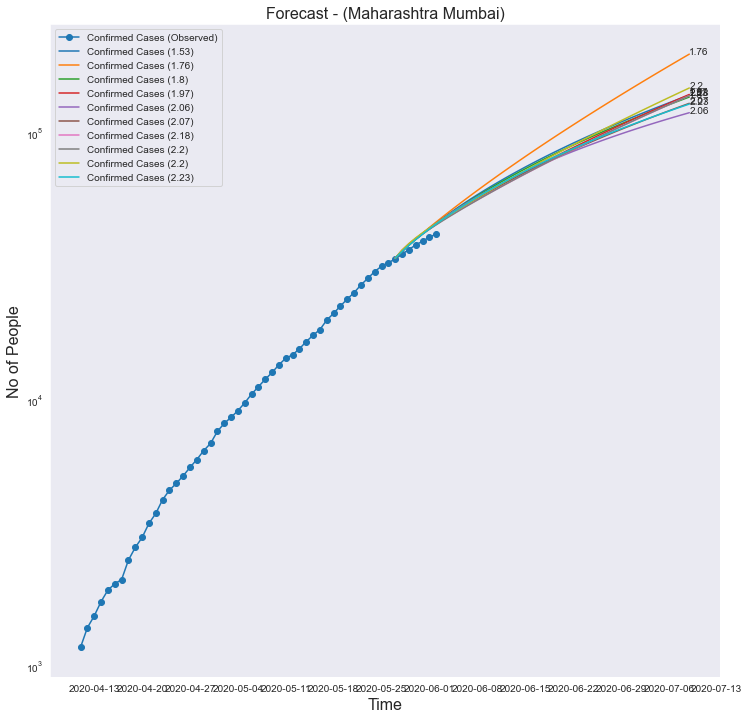

In [21]:
df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m1']['df_district']
#df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m2']['df_district']

#sns.set_style("ticks")
#sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_true['date'], df_true['total_infected'],
        '-o', color='C0', label='Confirmed Cases (Observed)')
for i, df_prediction in enumerate(predictions_array):
    loss_value = np.around(np.sort(losses_array)[:10][i], 2)
    sns.lineplot(x="date", y="total_infected", data=df_prediction,
                 ls='-', label='Confirmed Cases ({})'.format(loss_value))
    plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['total_infected'].iloc[-1], s=loss_value)
    
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People', fontsize=16)
plt.yscale('log')
plt.xlabel('Time', fontsize=16)
plt.legend()
plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
#plt.grid()
plt.show()     

In [22]:
df_true

,state,district,date,total_infected,hospitalised,recovered,deceased
46,maharashtra,mumbai,2020-04-11,1182,1036,71,75
47,maharashtra,mumbai,2020-04-12,1399,1211,97,91
48,maharashtra,mumbai,2020-04-13,1549,1308,141,100
49,maharashtra,mumbai,2020-04-14,1753,1478,164,111
50,maharashtra,mumbai,2020-04-15,1936,1642,181,113
51,maharashtra,mumbai,2020-04-16,2043,1725,202,116
52,maharashtra,mumbai,2020-04-17,2120,1760,239,121
53,maharashtra,mumbai,2020-04-18,2509,2103,281,125
54,maharashtra,mumbai,2020-04-19,2798,2357,310,131
55,maharashtra,mumbai,2020-04-20,3050,2518,394,138


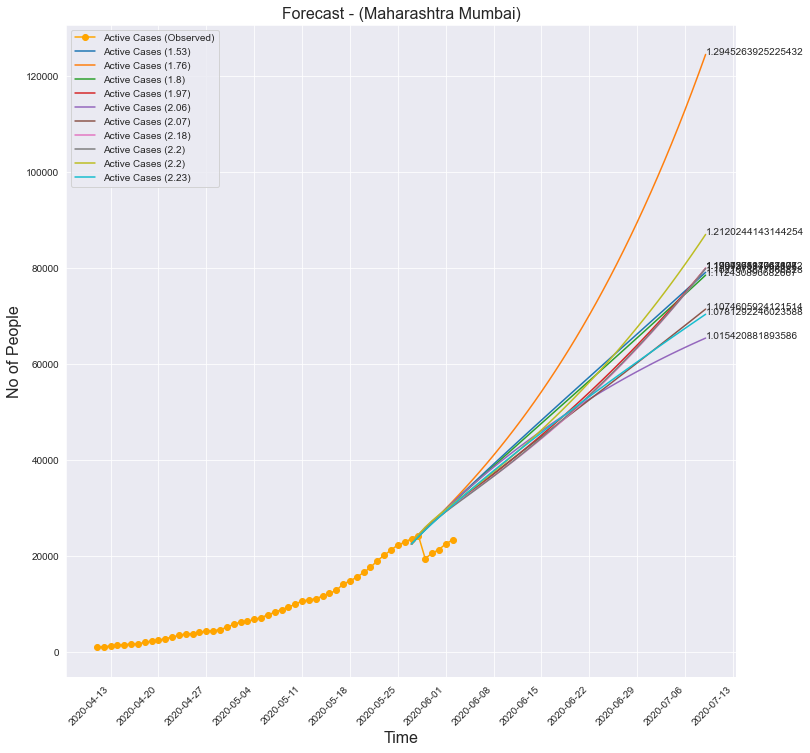

In [23]:
df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m1']['df_district']
#df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m2']['df_district']
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_true['date'], df_true['hospitalised'],
        '-o', color='orange', label='Active Cases (Observed)')
for i, df_prediction in enumerate(predictions_array):
    loss_value = np.around(np.sort(losses_array)[:10][i], 2)
    params_dict = params_array[least_losses_indices[:10]]
    true_r0 = params_dict[i]['lockdown_R0'] #np.around(params_dict[i]['lockdown_R0']*params_dict[i]['intervention_amount'], 2)
    #if true_r0 > 1.7:
    #    continue
    #if true_r0 == 0.59 or true_r0 == 1.04:
    #    continue
    sns.lineplot(x="date", y="hospitalised", data=df_prediction,
                 ls='-', label='Active Cases ({})'.format(loss_value))
    plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['hospitalised'].iloc[-1], s=true_r0)
    
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People', fontsize=16)
# plt.yscale('log')
plt.xlabel('Time', fontsize=16)
plt.xticks(rotation=45,horizontalalignment='right')
plt.legend()
plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
#plt.grid()
plt.show()     

## Check varying R0 values

In [24]:
params_to_plot = \
{
    'low':{'E_hosp_ratio': 0.115406221316017, 'I_hosp_ratio': 0.4763871081949848, 'P_fatal': 0.050419345187462467, 'P_severe': 0.7809853621826006, 'T_inc': 4.484977212179257, 'T_inf': 3.3342249004558697, 'T_recov_severe': 52.054485355979445, 'lockdown_R0': 1.0974118812671074},
    'medium':{'E_hosp_ratio': 0.5105188613649609, 'I_hosp_ratio': 0.3039459885534656, 'P_fatal': 0.05832975188719784, 'P_severe': 0.8668707539589996, 'T_inc': 4.554494614633725, 'T_inf': 3.3958101193846915, 'T_recov_severe': 48.49542471232895, 'lockdown_R0': 1.1227557408135034},
    'high':   {'E_hosp_ratio': 0.2806960144261442, 'I_hosp_ratio': 0.3800638057872212, 'P_fatal': 0.05326820833691313, 'P_severe': 0.8339542948758695, 'T_inc': 4.304052648857938, 'T_inf': 3.4673218430188513, 'T_recov_severe': 47.044942872805294, 'lockdown_R0': 1.3444274930627533}
}
multipliers = [0.9, 1, 1.1, 1.25]
columns_for_csv = ['date', 'total_infected', 'hospitalised', 'recovered', 'deceased']


In [25]:
def set_r0_multiplier(params_dict, mul):
    new_params = params_dict.copy()
    new_params['post_lockdown_R0']= params_dict['lockdown_R0']*mul
    return new_params


predictions_array_mul = [get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                  best_params=set_r0_multiplier(best_params_dict, mul)) \
                                 for mul in multipliers]

NameError: name 'best_params_dict' is not defined

In [ ]:
df_district = predictions_dict[districts_to_show[0]]['m2']['df_district']
df_train_nora, df_val_nora, df_true_fitting = train_val_split(
                df_district, train_rollingmean=False, val_rollingmean=False, val_size=0)

for key in params_to_plot:
    print("R0", params_to_plot[key]['lockdown_R0'])
    best_params_dict = params_to_plot[key]#predictions_dict[districts_to_show[0]]['m2']['best_params']
    df_predictions = get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                train_fit = "m2",
                                best_params = best_params_dict)
    df_loss = calculate_loss(df_train_nora, df_val_nora, df_predictions, train_period=7,
                             which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    print(df_loss)
    #print(df_loss.sum())

In [ ]:
df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m2']['df_district']
params_array[least_losses_indices[:10]]
for key in params_to_plot:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.plot(df_true['date'], df_true['hospitalised'],
        '-o', color='orange', label='Active Cases (Observed)')
    best_params_dict = params_to_plot[key]#predictions_dict[districts_to_show[0]]['m2']['best_params']
    predictions_array_mul = [get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                train_fit = "m2",
                                best_params=set_r0_multiplier(best_params_dict, mul))
                                 for mul in multipliers]
    for i, df_prediction in enumerate(predictions_array_mul):
        filename = "Mumbai-" + key + "-" + str(multipliers[i]) + ".csv"
        print(filename)
        today = datetime.date.today().strftime("%Y-%m-%d")
        path = f'../../outputs/Mumbai-{today}/'
        if not os.path.exists(path):
            os.mkdir(path)
        df_prediction[columns_for_csv].to_csv(os.path.join(path, filename))
        #loss_value = np.around(np.sort(losses_array)[:10][i], 2)
        label = multipliers[i]
        true_r0 = label*best_params_dict['lockdown_R0'] #np.around(params_dict[i]['lockdown_R0']*params_dict[i]['intervention_amount'], 2)
        #if true_r0 > 1.7:
        #    continue
        #if true_r0 == 0.59 or true_r0 == 1.04:
        #    continue
        sns.lineplot(x="date", y="hospitalised", data=df_prediction,
                     ls='-', label='Active Cases ({})'.format(label))
        plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['hospitalised'].iloc[-1], s=true_r0)

    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.ylabel('No of People', fontsize=16)
    # plt.yscale('log')
    plt.xticks(rotation=45,horizontalalignment='right')

    plt.xlabel('Time', fontsize=16)
    plt.legend()
    plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
    #plt.grid()
    plt.show()     

In [ ]:

for elt in params_array[least_losses_indices[:10]]:
    print("R0", elt['lockdown_R0'])
    #best_params_dict = params_to_plot[key]#predictions_dict[districts_to_show[0]]['m2']['best_params']
    df_predictions = get_forecast(
        predictions_dict[('Maharashtra', 'Mumbai')],
        train_fit = "m1",
        best_params = elt)
    df_loss = calculate_loss(
        df_train_nora, df_val_nora, df_predictions, train_period=7,
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    print(df_loss.iloc[1])


In [ ]:
columns = ['forecastRunDate', 'regionType', 'region', 'model_name', 'error_function', 'error_value', 'current_total', 'current_active', 'current_recovered',
           'current_deceased', 'current_hospitalized', 'current_icu', 'current_ventilator', 'predictionDate', 'active_mean', 'active_min',
           'active_max', 'hospitalized_mean', 'hospitalized_min', 'hospitalized_max', 'icu_mean', 'icu_min', 'icu_max', 'deceased_mean',
           'deceased_min', 'deceased_max', 'recovered_mean', 'recovered_min', 'recovered_max', 'total_mean', 'total_min', 'total_max']

region = ('Maharashtra', 'Mumbai')

df_final = pd.DataFrame(columns=columns)
for params_dict in params_array[least_losses_indices[:10]]:
    df_output = create_region_csv(predictions_dict[region], region=region[1],
    regionType='district', best_params=params_dict,
    icu_fraction=0.02)
    df_final = pd.concat([df_final, df_output], ignore_index=True)
    

In [ ]:
df_final.to_csv('../../outputs/mumbai-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [ ]:
df_final

In [ ]:
for index, params_dict in enumerate(params_array[least_losses_indices[:10]]):
    print('Loss - ', np.around(losses_array[least_losses_indices[:10][index]], 2))
    params_dict_temp = copy.copy(params_dict)
    params_dict_temp['true_R0'] = params_dict_temp['lockdown_R0']#*params_dict_temp['intervention_amount']
    #del params_dict_temp['intervention_amount']
    del params_dict_temp['lockdown_R0']
    for key in params_dict_temp.keys():
        params_dict_temp[key] = np.around(params_dict_temp[key], 2)
    print('Params - ', params_dict_temp)
    print('\n')

# Find beta and mean params for uncertainty estimation

In [26]:
params_array

array([{'E_hosp_ratio': 0.6470296635147346, 'I_hosp_ratio': 0.7991809220520073, 'P_fatal': 0.28739551871944097, 'T_inc': 4.710657049704672, 'T_inf': 3.7010554995461353, 'T_recov_severe': 56.6758191849674, 'lockdown_R0': 1.2561470169414382},
       {'E_hosp_ratio': 0.03761421776444185, 'I_hosp_ratio': 0.957603383385793, 'P_fatal': 0.0725810637001469, 'T_inc': 4.330782636522582, 'T_inf': 3.164980871986222, 'T_recov_severe': 36.923240112892955, 'lockdown_R0': 1.4646797409554275},
       {'E_hosp_ratio': 1.1274715664530395, 'I_hosp_ratio': 0.13699023134700816, 'P_fatal': 0.2647438448730203, 'T_inc': 4.8531741298128495, 'T_inf': 3.6775091677792395, 'T_recov_severe': 32.77667140814012, 'lockdown_R0': 1.344966587562635},
       ...,
       {'E_hosp_ratio': 0.19937668346561954, 'I_hosp_ratio': 0.43636430061938847, 'P_fatal': 0.07023567606970353, 'T_inc': 4.474176489329809, 'T_inf': 3.24329654684115, 'T_recov_severe': 49.516569018971914, 'lockdown_R0': 1.1378926130219806},
       {'E_hosp_ratio

In [27]:
params_list = list(params_array[0].keys())

In [56]:
num_samples=range(10,2000,10)
betas= np.arange(0,5,0.2)
param_mean={}
param_stdev={}

params_fulldict = params_array[least_losses_indices]
params_list = list(params_array[0].keys())
means = {}
std_devs = {}
sums = {}
sqsums = {}

for i, beta in enumerate(betas):
    means[i] = {}
    std_devs[i] = {}
    for key in params_list:
        means[i][key] = []
        std_devs[i][key] = []
    for nums in num_samples:
        Loss_norm=0
        for key in params_list:
            sums[key] = 0
            sqsums[key] = 0
        tempdict = params_fulldict[0:nums]
        templosses = losses_array[least_losses_indices[0:nums]]
        for k in range(len(tempdict)):
            Loss_norm += np.exp(-beta*templosses[k])
            for key in params_list:
                sums[key] += np.exp(-beta*templosses[k])*tempdict[k][key]
                sqsums[key] += np.exp(-beta*templosses[k])*tempdict[k][key]**2
        for key in params_list:
            means[i][key].append(sums[key]/Loss_norm)
            std_devs[i][key].append(np.sqrt(sqsums[key]/Loss_norm-(sums[key]/Loss_norm)**2))
                

In [57]:
means[0]['E_hosp_ratio'][-5:]

[0.4129845961020859,
 0.4129845961020859,
 0.4129845961020859,
 0.4129845961020859,
 0.4129845961020859]

In [58]:
means[betaind][key]

[1.1489223359910095,
 1.1700926297895449,
 1.174454642093682,
 1.1834211278043096,
 1.1828410916008298,
 1.1735114778902844,
 1.1725095681322268,
 1.1747541702484927,
 1.1718749252392227,
 1.17410466628511,
 1.17300809286283,
 1.1729781909215637,
 1.1738180670918215,
 1.1726184047935417,
 1.174452293129821,
 1.175583167997712,
 1.1748799969995152,
 1.1721997382969351,
 1.1702949497636503,
 1.1700355170374181,
 1.1694509019474222,
 1.1715753090698555,
 1.1715603219226463,
 1.1726777342850443,
 1.1710024417471505,
 1.1718151605936187,
 1.170952233313333,
 1.1671691785267193,
 1.1670762922291595,
 1.1682080939103852,
 1.1683941731201204,
 1.1698544658579497,
 1.1708135796522194,
 1.1686390671013172,
 1.1674237409913262,
 1.1665917438434208,
 1.1668468555106803,
 1.1674754659702757,
 1.1675641552549538,
 1.1680998966846143,
 1.1686039363143361,
 1.1680718353398563,
 1.1678069336577308,
 1.1688139064371512,
 1.1681614421821684,
 1.1683825853074135,
 1.1684464912083208,
 1.1686594447242864,


In [59]:
[t for t in num_samples]

[10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220,
 230,
 240,
 250,
 260,
 270,
 280,
 290,
 300,
 310,
 320,
 330,
 340,
 350,
 360,
 370,
 380,
 390,
 400,
 410,
 420,
 430,
 440,
 450,
 460,
 470,
 480,
 490,
 500,
 510,
 520,
 530,
 540,
 550,
 560,
 570,
 580,
 590,
 600,
 610,
 620,
 630,
 640,
 650,
 660,
 670,
 680,
 690,
 700,
 710,
 720,
 730,
 740,
 750,
 760,
 770,
 780,
 790,
 800,
 810,
 820,
 830,
 840,
 850,
 860,
 870,
 880,
 890,
 900,
 910,
 920,
 930,
 940,
 950,
 960,
 970,
 980,
 990,
 1000,
 1010,
 1020,
 1030,
 1040,
 1050,
 1060,
 1070,
 1080,
 1090,
 1100,
 1110,
 1120,
 1130,
 1140,
 1150,
 1160,
 1170,
 1180,
 1190,
 1200,
 1210,
 1220,
 1230,
 1240,
 1250,
 1260,
 1270,
 1280,
 1290,
 1300,
 1310,
 1320,
 1330,
 1340,
 1350,
 1360,
 1370,
 1380,
 1390,
 1400,
 1410,
 1420,
 1430,
 1440,
 1450,
 1460,
 1470,
 1480,
 1490,
 1500,
 1510,
 1520,
 1530,
 1540,
 1550,
 1560,
 1570,
 1580,
 1

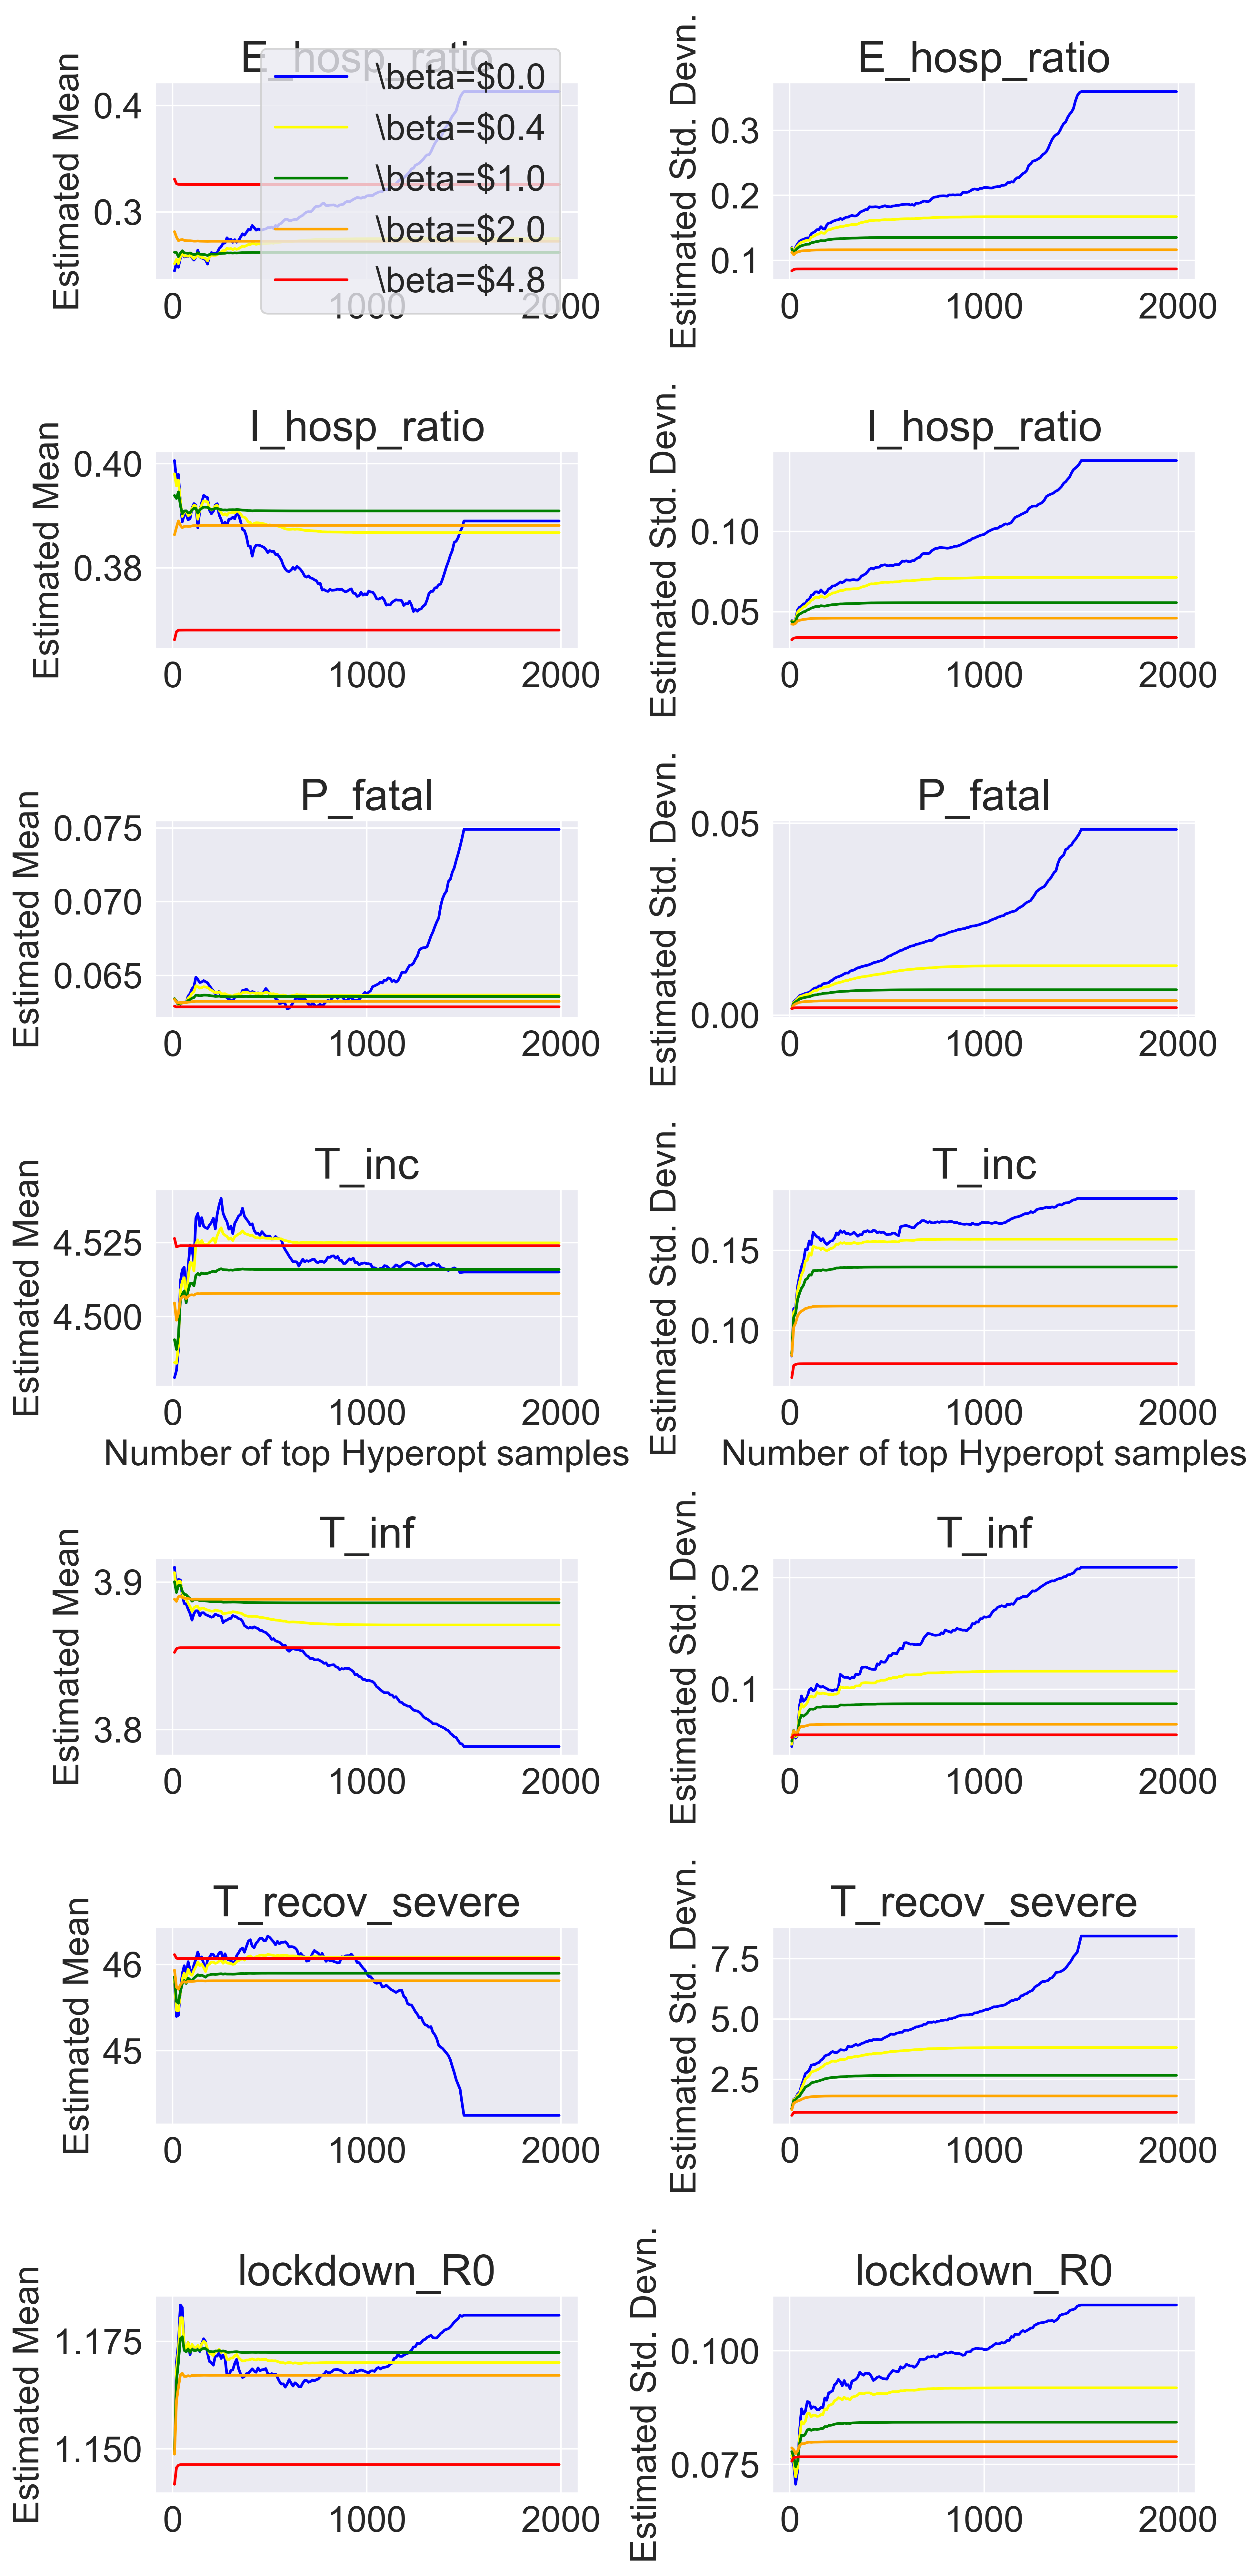

In [60]:
fig, axs = plt.subplots(len(params_list),2)
plt.rcParams['figure.dpi']=400
plt.rcParams['figure.figsize']=[50, 75]
plt.rcParams.update({'font.size':20})
colors =['blue','yellow','green','orange','red']
for row, key in enumerate(params_list):
    for idx, betaind in enumerate([0,2,5,10,24]):
        axs[row,0].plot(num_samples, means[betaind][key] , color = colors[idx],label=r'\beta=${:.1f}'.format(betas[betaind]))
        axs[row,0].set_title('{}'.format(key))
        axs[row,0].set(ylabel= "Estimated Mean")
        axs[row,1].plot(num_samples,std_devs[betaind][key], color = colors[idx],label=r'$\beta=${:.1f}'.format(betas[betaind]))
        axs[row,1].set_title('{}'.format(key))
        axs[row,1].set(ylabel="Estimated Std. Devn.")
        if (row==0):
            axs[row,0].legend(loc='center right')
        if (row==3):
            axs[row,0].set(xlabel="Number of top Hyperopt samples")
            axs[row,1].set(xlabel="Number of top Hyperopt samples")

fig.tight_layout(pad=1.0)

In [32]:
# Define N from plots!
N = 1500

In [33]:
len(means[i][key])

199

In [34]:
def get_loss(i):
    skip_length = 10
    mean_params = {key:means[i][key][N // skip_length] for key in params_list}
    df_train = predictions_dict[districts_to_show[0]]['m1']['df_train']
    df_val = predictions_dict[districts_to_show[0]]['m1']['df_val']
    df_predictions= get_forecast(predictions_dict[districts_to_show[0]],
                                train_fit='m1',
                                best_params=mean_params)
    df_loss = calculate_loss(df_train, df_val, df_predictions, train_period=7,
                                 which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    return df_loss

In [35]:
losses = [get_loss(i) for i in range(len(betas))]
val_losses = [loss['val'].sum() for loss in losses]
min_loss_ind = np.argmin(val_losses)
beta_min = betas[min_loss_ind]

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


In [36]:
print(beta_min )

1.4000000000000001


# Generate uncertainty estimates

In [71]:
params_array_m2 = []
for trial in predictions_dict[(state, district)]['m2']['trials']:
#for trial in predictions_dict[(state, district)]['m2']['trials']:
    params_dict = copy.copy(trial['misc']['vals'])
    for key in params_dict.keys():
        params_dict[key] = params_dict[key][0]
    params_array_m2.append(params_dict)

params_array_m2= np.array(params_array_m2)

In [72]:
nums= N
betas=[beta_min] #np.arange(0,5,0.2)
param_mean={}
param_stdev={}

params_fulldict_m2 = params_array_m2[least_losses_indices]
means = {}
std_devs = {}
sums = {}
sqsums = {}

for i, beta in enumerate(betas):
    means[i] = {}
    std_devs[i] = {}
    for key in params_list:
        means[i][key] = []
        std_devs[i][key] = []
    Loss_norm=0
    for key in params_list:
        sums[key] = 0
        sqsums[key] = 0
    tempdict = params_fulldict[0:nums]
    templosses = losses_array[least_losses_indices[0:nums]]
    for k in range(len(tempdict)):
        Loss_norm += np.exp(-beta*templosses[k])
        for key in params_list:
            sums[key] += np.exp(-beta*templosses[k])*tempdict[k][key]
            sqsums[key] += np.exp(-beta*templosses[k])*tempdict[k][key]**2
    for key in params_list:
        means[i][key].append(sums[key]/Loss_norm)
        std_devs[i][key].append(np.sqrt(sqsums[key]/Loss_norm-(sums[key]/Loss_norm)**2))


In [73]:
best_params_m2 = params_fulldict_m2[:N]
losses_array_m2 = np.array([trial['result']['loss'] for trial in predictions_dict[(state, district)]['m2']['trials']])
best_params_total_loss_m2 = sum(np.exp(-beta_min * losses_array[least_losses_indices[:N]]))

In [74]:
losses_array[least_losses_indices[:N]][:50]

array([1.52606616, 1.75647004, 1.80342187, 1.97262928, 2.05656601,
       2.07104565, 2.18456168, 2.19766594, 2.19867336, 2.2329167 ,
       2.27130259, 2.27145054, 2.30463311, 2.33517508, 2.45990793,
       2.47065253, 2.4945097 , 2.57168123, 2.62506757, 2.63822416,
       2.66470197, 2.71378464, 2.79764553, 2.80265721, 2.81346708,
       2.8566029 , 2.87394773, 2.88673009, 2.91459163, 2.98722568,
       2.99996138, 3.04670283, 3.0483807 , 3.04876163, 3.06813858,
       3.12976451, 3.15129699, 3.19164527, 3.19585341, 3.2519237 ,
       3.28169958, 3.28835684, 3.32687604, 3.3614878 , 3.44498281,
       3.45152597, 3.48066334, 3.49016047, 3.5100363 , 3.51051864])

In [75]:
def get_preds_m2():    
    mean_params = {key:means[0][key][0] for key in params_list}
    df_train = predictions_dict[districts_to_show[0]]['m2']['df_train']
    df_val = predictions_dict[districts_to_show[0]]['m2']['df_val']
    df_predictions= get_forecast(predictions_dict[districts_to_show[0]],
                                train_fit='m2',
                                best_params=mean_params)
    return df_predictions, mean_params

def get_loss_m2(params):
    N = 1500
    skip_length = 10
    df_train = predictions_dict[districts_to_show[0]]['m2']['df_train']
    df_val = predictions_dict[districts_to_show[0]]['m2']['df_val']
    df_predictions= get_forecast(predictions_dict[districts_to_show[0]],
                                train_fit='m2',
                                best_params=params)
    df_loss = calculate_loss(df_train, df_val, df_predictions, train_period=7,
                                 which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    return df_loss

In [76]:

m2_losses = [get_loss_m2(params)['train'] for params in best_params_m2]

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

In [77]:
all_forecasts = pd.DataFrame()
for params in best_params_m2:
    all_forecasts = pd.concat([all_forecasts , get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                                train_fit='m2',
                                                best_params=params)], axis = 1)

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forec

In [78]:
means

{0: {'E_hosp_ratio': [0.26421369237679687],
  'I_hosp_ratio': [0.3904836821903467],
  'P_fatal': [0.06338920677394963],
  'T_inc': [4.510503979695004],
  'T_inf': [3.888913135488981],
  'T_recov_severe': [45.83126577060667],
  'lockdown_R0': [1.171086471272509]}}

In [79]:
def gen_CI(day = 1, compartment = 'hospitalised'):
    daily_forecasts = all_forecasts[compartment].iloc[day,:]
    argsorted_daily_forecasts = np.argsort(daily_forecasts)
    sorted_daily_forecasts = np.sort(daily_forecasts)
    sorted_losses_array = (losses_array[least_losses_indices[:N]])[argsorted_daily_forecasts]
    threshold = 0.025 * best_params_total_loss_m2
    upperbound = N-1
    lowerbound = 0 
    upperscore, lowerscore = 0, 0
    while upperscore < threshold:
        upperscore += np.exp(- beta_min*sorted_losses_array[upperbound])
        upperbound -= 1
    while lowerscore < threshold:
        lowerscore += np.exp(- beta_min*sorted_losses_array[lowerbound])
        lowerbound += 1
    lower_forecast = sorted_daily_forecasts[lowerbound]
    upper_forecast = sorted_daily_forecasts[upperbound]
    return all_forecasts['date'].iloc[day,0], lower_forecast, upper_forecast

In [82]:
full_data

,date,hospitalised,hospitalised,hospitalised
0,2020-05-27,22560,22560,22560
1,2020-05-28,20901,23438,24200
2,2020-05-29,19616,24716,25666
3,2020-05-30,18595,27533,27034
4,2020-05-31,17768,29776,28341
5,2020-06-01,17067,31372,29615
6,2020-06-02,16532,33249,30876
7,2020-06-03,16057,35454,32128
8,2020-06-04,15755,37767,33381
9,2020-06-05,15422,40394,34638


getting forecasts ..


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

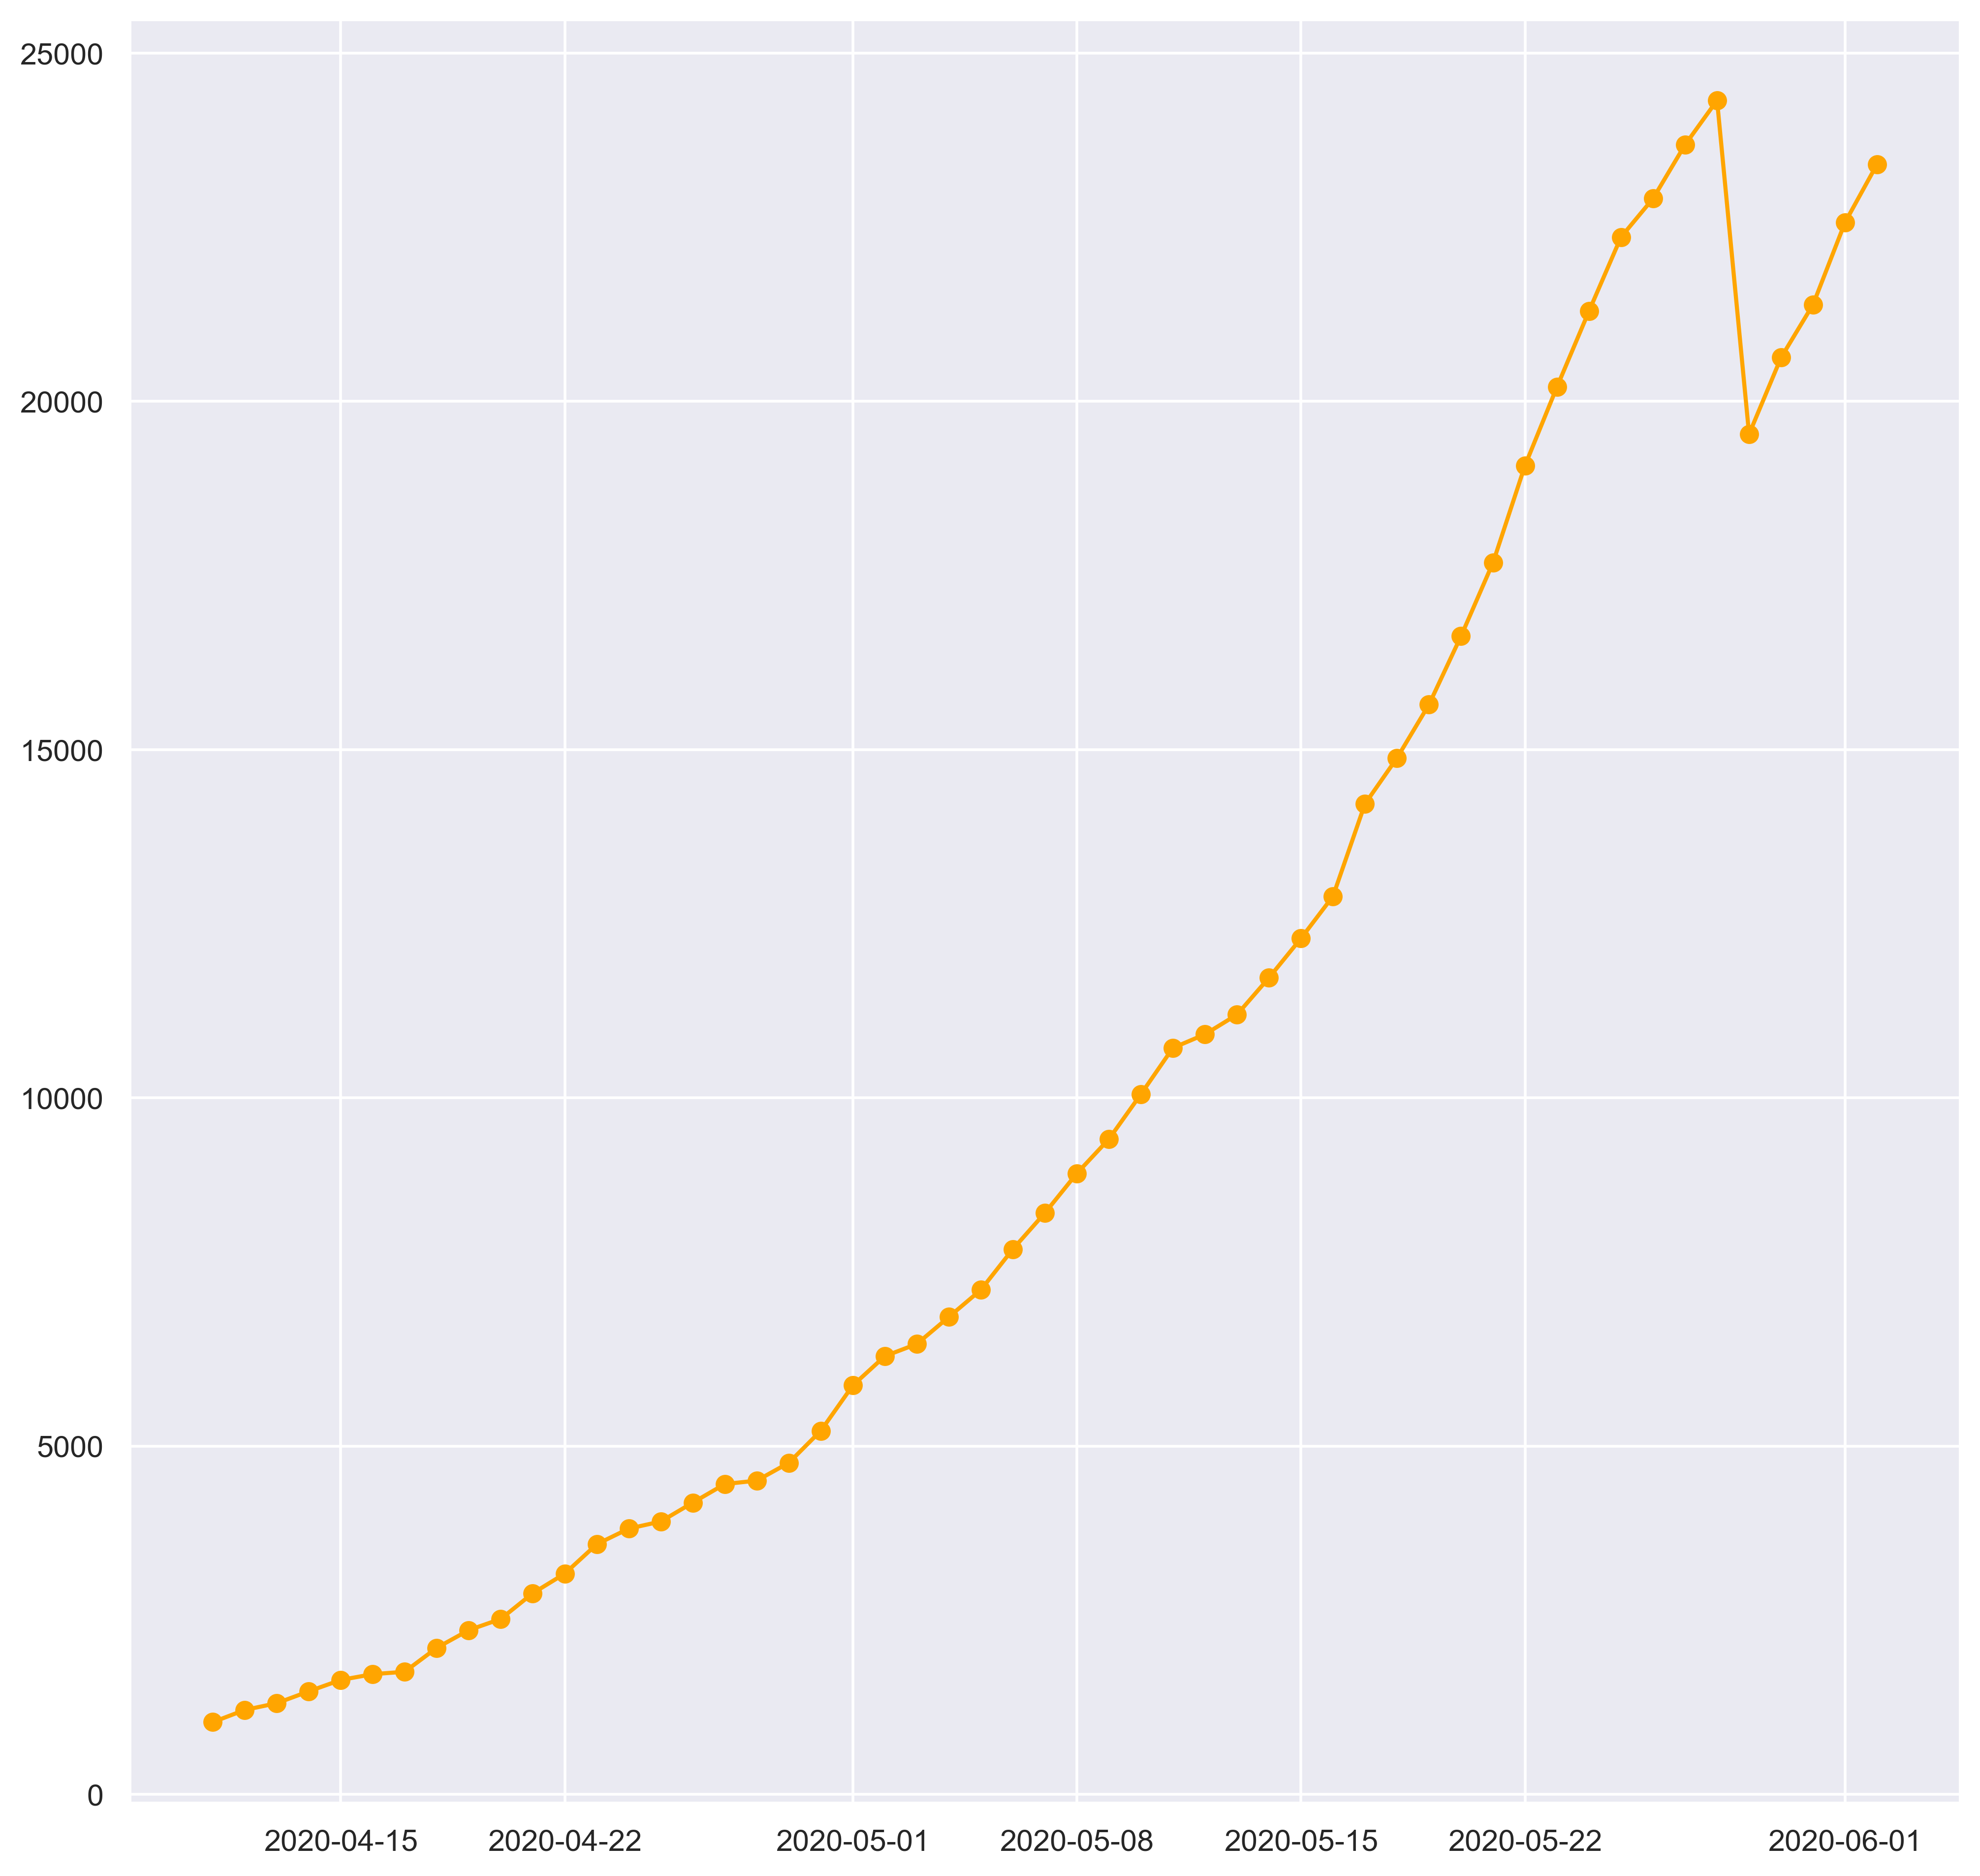

In [90]:
#df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m1']['df_district']
df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m2']['df_district']
df_predictions, mean_params = get_preds_m2()
sns.set()
#sns.set_style("darkgrid")
colors = ['orange', 'blue', 'red', 'green']
ci_cols = {}
fig, ax = plt.subplots(figsize=(12, 12))
for idx, compartment in enumerate(['hospitalised', 'total_infected', 'deceased', 'recovered']):
    ax.plot(df_true['date'], df_true[compartment],
            '-o', color= colors[idx], label= compartment)
    ci_cols[idx] = pd.DataFrame([gen_CI(i, compartment) for i in range(len(all_forecasts))])
    ci_cols[idx].columns = ['date', 'lower', 'upper']
    full_data = pd.concat([ci_cols[idx], df_predictions[compartment]], axis =1)
    sns.lineplot(data =full_data, y =  compartment,  x ='date' , 
                 err_style = "band", 
                 err_kws = {'x': ci_cols[idx].columns['date'], 'y1':ci_cols[idx].columns['lower'],
                            'y2':ci_cols[idx].columns['upper']},
                 ls='-', color = colors[idx], label= compartment+" prediction" )
    """sns.lineplot(data = df_predictions, y = compartment,  x ='date' ,
                 ls='-', color = colors[idx], label= compartment+" prediction" ) 
    
    sns.lineplot(data = ci_cols[idx], x ='date' , y='lower', dashes = True, color = colors[idx])
    ax.lines[-1].set_linestyle("--")
    sns.lineplot(data = ci_cols[idx], x ='date' , y='upper', dashes = True, color = colors[idx])
    ax.lines[-1].set_linestyle("--")"""
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People', fontsize=16)
# plt.yscale('log')
plt.xlabel('Time', fontsize=16)
plt.xticks(rotation=45,horizontalalignment='right')
plt.legend()
plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
#plt.grid()
plt.show()   